In [91]:
# visualization
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

# utils
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import catboost as cb
from catboost import CatBoostRegressor

from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import re

In [2]:
train_path = '../data/train.csv'
test_path = '../data/test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

### Train, Test 데이터 합치기

In [3]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df_train['is_test'] = 0
df_test['is_test'] = 1
df_total = pd.concat([df_train, df_test])     # 하나의 데이터로 만들어줍니다.

### 전처리하기

In [4]:
df_copy = df_total.copy()

#### 시군구

In [5]:
def split_country(word:str):
    return word.split()[1]

def split_district(word:str):
    return word.split()[-1]

In [6]:
# 시, 군, 구로 분할하기

# 군
df_copy['군'] = df_copy['시군구'].apply(split_country)
display(df_copy['군'][:3])

# 구
df_copy['구'] = df_copy['시군구'].apply(split_district)
display(df_copy['구'][:3])

# 시군구 column 제거하기
df_copy.drop('시군구', axis=1, inplace=True)

0    강남구
1    강남구
2    강남구
Name: 군, dtype: object

0    개포동
1    개포동
2    개포동
Name: 구, dtype: object

#### 번지, 본번, 부번

In [7]:
# 결측치 채우기

# 서초포레스타2단지: 45-0
# 힐스테이트 서초 젠트리스: 10-12

df_temp = df_copy[['번지', '본번', '부번', '아파트명']].copy()

df_temp.loc[df_temp['아파트명'] == '서초포레스타2단지', ['본번']] = 45.0
df_temp.loc[df_temp['아파트명'] == '서초포레스타2단지', ['부번']] = 0.0

df_temp.loc[df_temp['아파트명'] == '힐스테이트 서초 젠트리스', ['본번']] = 10.0
df_temp.loc[df_temp['아파트명'] == '힐스테이트 서초 젠트리스', ['부번']] = 12.0

In [8]:
# 본번과 부번 형변환(str)
df_temp['본번'] = df_temp['본번'].astype('int').astype('str')
df_temp['부번'] = df_temp['부번'].astype('int').astype('str')

df_copy['본번'] = df_temp['본번']
df_copy['부번'] = df_temp['부번']

# 번지 column 제거하기
df_copy.drop('번지', axis=1, inplace=True)

#### 아파트명

In [9]:
def crawling(querys, url='https://www.epost.go.kr/search.RetrieveIntegrationNewZipCdList.comm'):
    result = dict()

    browser = webdriver.Chrome()
    browser.get(url)
    time.sleep(1)

    for query in querys:
        browser.find_element(By.XPATH, '//*[@id="keyword"]').clear()
        browser.find_element(By.XPATH, '//*[@id="keyword"]').click()
        browser.implicitly_wait(2)
    
        browser.find_element(By.XPATH, '//*[@id="keyword"]').send_keys(query)
        browser.implicitly_wait(2)

        browser.find_element(By.ID, 'btnZipSearch').click()
        browser.implicitly_wait(2)

        time.sleep(1.5)
    
        text = browser.find_element(By.XPATH, '//*[@id="body_layout"]/div/div[1]/div[2]/div/div/div/div/table/tbody/tr[1]/td[1]').text
        result[query] = text
    
    return result

In [10]:
def extract_apartment(dictionary):
    result = dict()

    for key in dictionary:
        # 0. \n을 기준으로 앞의 문자열 택하기
        first_part = dictionary[key].split('\n')[0]

        # 괄호로 이루어진 문자열에서
        # 1. (xx동, yy)패턴이라면 yy를 추출한다.
        pattern1 = re.search(r'\((.*?동), (.*?)\)', first_part)
        if pattern1:
            result[key] = pattern1.group(2)
            continue

        # 2. (yy)패턴이라면 yy를 추출한다. (단, yy는 '동'으로 끝나지 않는다.)
        pattern2 = re.search(r'\((.*?)\)', first_part)
        if pattern2:
            extracted = pattern2.group(1)
            if not extracted.endswith('동'):
                result[key] = extracted
                continue
    
    return result

In [11]:
result = {'서울특별시 구로구 구로동 751-37': '영진빌라', '서울특별시 구로구 구로동 740-6': '청우아트빌라2차', 
          '서울특별시 성동구 행당동 1-10': '아파트', '서울특별시 동대문구 장안동 404-13': '아이엔에스새터아파트', 
          '서울특별시 구로구 구로동 718-7': '경원주택', '서울특별시 종로구 창신동 436-79': '대성약국', 
          '서울특별시 구로구 구로동 770-23': '수도빌라', '서울특별시 구로구 구로동 792-78': '미도빌라', 
          '서울특별시 서초구 서초동 1617-21': 'calliavill', '서울특별시 구로구 구로동 747-52': '무성빌라', 
          '서울특별시 구로구 구로동 792-86': '고대빌라', '서울특별시 강서구 화곡동 46-220': '힐탑아파트', 
          '서울특별시 구로구 구로동 743-27': '계영주택', '서울특별시 종로구 연건동 60-1': '연건동아파트', 
          '서울특별시 송파구 방이동 185-5': '올림픽아트빌', '서울특별시 구로구 구로동 743-10': '백합빌라', 
          '서울특별시 은평구 신사동 23-42': '우일아파트', '서울특별시 성북구 안암동5가 160-16': '안암동5가', 
          '서울특별시 구로구 구로동 743-5': '혜원주택', '서울특별시 구로구 구로동 752-37': '청송아트빌라', 
          '서울특별시 마포구 신수동 91-511': '신수동자이언트아파트', '서울특별시 구로구 구로동 751-32': '나영빌라', 
          '서울특별시 구로구 구로동 749-1': '제일빌라', '서울특별시 구로구 구로동 740-25': '방현빌라', 
          '서울특별시 서초구 양재동 66-3': '한일인텔빌라', '서울특별시 구로구 구로동 752-13': '성진빌라', 
          '서울특별시 종로구 명륜3가 1-102': '명륜3가', '서울특별시 종로구 숭인동 204-11': '숭인상가아파트', 
          '서울특별시 동작구 대방동 99-1': '효성아파트', '서울특별시 동작구 상도동 323-4': '상진빌딩', 
          '서울특별시 강서구 염창동 248-7': '염창하이츠빌딩', '서울특별시 구로구 구로동 750-13': '계영주택', 
          '서울특별시 구로구 구로동 718-28': '아트빌라', '서울특별시 영등포구 대림동 1101-1': '유탑유블레스', 
          '서울특별시 중구 신당동 372-66': '다다유크레스', '서울특별시 중구 신당동 432-2001': '석종아파트', 
          '서울특별시 강남구 역삼동 828-21': '뜨라네', '서울특별시 강남구 역삼동 828-76': '뜨라네', 
          '서울특별시 구로구 구로동 747-51': '무성빌라', '서울특별시 관악구 봉천동 685-103': '보람아파트', 
          '서울특별시 동대문구 장안동 400-3': '해오름아파트', '서울특별시 중구 신당동 432-904': '성민아트', 
          '서울특별시 구로구 구로동 743-39': '경원주택', '서울특별시 구로구 구로동 747-53': '무성빌라', 
          '서울특별시 구로구 구로동 746-17': '진웅빌라'}

In [12]:
df_temp = df_total.copy()
df_temp['지번주소'] = df_temp['시군구'] + ' ' + df_temp['번지']

# 1. 시군구 + 번지 합치기 (set)
name_set = set()
name_set.update(df_temp.loc[df_temp['아파트명'].isna(), '지번주소'])

# 2. 크롤링
# buffer = crawling(list(name_set))
# print(buffer)
# result = extract_apartment(buffer)
# print(result)
# result --> 지번주소: 아파트이름

# 3. 결측치 채우기
df_temp.loc[df_temp['아파트명'].isna(), '아파트명'] = df_temp.loc[df_temp['아파트명'].isna(), '지번주소'].map(result)
df_copy['아파트명'] = df_temp['아파트명']

In [13]:
# 남은 결측치 NULL 처리
df_copy.loc[df_copy['아파트명'].isna(), '아파트명'] = 'NULL'

#### 전용면적(㎡)

In [14]:
# column 이름 바꾸기
df_copy['전용면적'] = df_copy['전용면적(㎡)']
df_copy.drop('전용면적(㎡)', axis=1, inplace=True)

In [15]:
# 비슷한 빈도를 가지는 10개의 구간으로 나누기
cut = pd.qcut(df_copy['전용면적'], q=10, labels=['전용면적_1', '전용면적_2', '전용면적_3', '전용면적_4', '전용면적_5', '전용면적_6', '전용면적_7', '전용면적_8', '전용면적_9', '전용면적_10'])
df_copy['전용면적'] = cut

#### 계약년월

In [16]:
df_copy['계약년'] = df_copy['계약년월'].astype('str').map(lambda x: x[:4]).astype('int')
df_copy['계약월'] = df_copy['계약년월'].astype('str').map(lambda x: x[4:]).astype('int')

df_copy.drop('계약년월', axis=1, inplace=True)

#### 해제사유발생일

In [17]:
df_copy['해제사유발생여부'] = df_copy['해제사유발생일'].notna()

#### k-단지분류(아파트,주상복합등등)

In [18]:
df_copy.loc[df_copy['k-단지분류(아파트,주상복합등등)'].isna(), 'k-단지분류(아파트,주상복합등등)'] = 'NULL'

In [19]:
df_copy['k-단지분류(아파트,주상복합등등)'].value_counts()

NULL              877273
아파트               238586
주상복합               11450
도시형 생활주택(주상복합)       505
도시형 생활주택(아파트)        155
연립주택                 125
Name: k-단지분류(아파트,주상복합등등), dtype: int64

#### k-세대타입(분양형태)

In [20]:
df_copy.loc[df_copy['k-세대타입(분양형태)'].isna(), 'k-세대타입(분양형태)'] = 'NULL'

In [21]:
df_copy['k-세대타입(분양형태)'].value_counts()

NULL    876125
분양      208098
기타       41638
임대        2233
Name: k-세대타입(분양형태), dtype: int64

#### k-관리방식

In [22]:
df_copy['관리방식유무'] = df_copy['k-관리방식'].notna()

df_copy.drop('k-관리방식', axis=1, inplace=True)

#### k-복도유형

In [23]:
df_copy['복도유형'] = np.where(((df_copy['k-복도유형'] == '타워형') | (df_copy['k-복도유형'] == '계단식')), True, False)

df_copy.drop('k-복도유형', axis=1, inplace=True)

#### k-난방방식

In [24]:
df_copy.loc[df_copy['k-난방방식'].isna(), 'k-난방방식'] = 'NULL'
df_copy['k-난방방식'].value_counts()

NULL    876125
개별난방    152365
지역난방     84826
중앙난방     12687
기타        2091
Name: k-난방방식, dtype: int64

#### k-전체세대수

In [25]:
# 전체세대수를 기준으로 group화 하여 평균 target값 구하기
df_temp = df_copy[['k-전체세대수', 'target']].copy()
temp = round(df_temp.groupby(['k-전체세대수'])['target'].mean(), 2)

# target threshold 정하기
# 상위 10%, 30%
target_threshlod_1 = int(temp.quantile(0.90))
target_threshlod_2 = int(temp.quantile(0.70))

temp = pd.DataFrame(temp)

quant_10_list = temp.loc[temp['target'] >= target_threshlod_1].index.to_list()
quant_30_list = temp.loc[(temp['target'] >= target_threshlod_2) & (temp['target'] < target_threshlod_1)].index.to_list()
quant_rest_list = temp.loc[temp['target'] < target_threshlod_2].index.to_list()

# 세 그룹으로 나누어 범주화하기
df_temp.loc[df_temp['k-전체세대수'].isin(quant_10_list), 'k-전체세대수'] = '전체세대수_1'
df_temp.loc[df_temp['k-전체세대수'].isin(quant_30_list), 'k-전체세대수'] = '전체세대수_2'
df_temp.loc[df_temp['k-전체세대수'].isin(quant_rest_list), 'k-전체세대수'] = '전체세대수_3'
df_temp.loc[df_temp['k-전체세대수'].isna(), 'k-전체세대수'] = 'NULL'


In [26]:
# test 데이터의 외삽이 나타난다.
df_temp['k-전체세대수'].value_counts()

NULL       876125
전체세대수_3    196503
전체세대수_2     37476
전체세대수_1     17988
614.0           2
Name: k-전체세대수, dtype: int64

In [27]:
# 값이 천차만별이기 때문에 다른 범주형으로 처리
df_temp.loc[(df_temp['k-전체세대수'] == 614.0) | (df_temp['k-전체세대수'] == 799.0) , 'k-전체세대수'] = '전체세대수_외삽'
df_temp['k-전체세대수'].value_counts()

NULL        876125
전체세대수_3     196503
전체세대수_2      37476
전체세대수_1      17988
전체세대수_외삽         2
Name: k-전체세대수, dtype: int64

In [28]:
df_copy['k-전체세대수'] = df_temp['k-전체세대수']

#### k-건설사(시공사)

In [29]:
construction_list = df_total['k-건설사(시공사)'].unique()
construction_list = construction_list.tolist()

In [30]:
construction_result = {}

def check(string):
    global construction_list

    temps = []

    for construction in construction_list:
        if str(construction).upper().find(string) != -1:
            temps.append(str(construction))
    
    for temp in temps:
        construction_list.remove(temp)

    construction_result[string] = temps

string_list = set(['우성', '박연정', '대한', '현대', '동양', '대우', '대림', '삼성',
                  '쌍용', '한보', '대성', '중앙', '세방', '태영', '고려',
                  '한라', '롯데', 'GS', '한화', '건영', '계룡', '수자인', '삼익',
                  '삼환', 'KR산업', '동부', '고속도로관리공단', 'SH', '남광', '청광',
                  'LG', '청구', '삼호', '한솔', '임광', '벽산', '홍익', '한양', '한진', '성지',
                  'KCC', '두산', 'TEC', '성원', '라인', '코오롱', '금호', '대보',
                  '경남', '서광', '우림', '삼환', '보람', '한일', '서희', 
                  '대호', '라이프', '갑을', 'SK', '우성', '인정', '재건축', '월드', '포스코',
                  '풍림', '한진', '신도', '도시개발공사', '효성', '세양', '럭키', '대백',
                  '극동', '주택공사', 'BYC', '신성', '동일', '신한', '경동', '극동', '남해',
                  'LIG', '경향', '라성', '해태', '동양', '재개발', '동원', '쌍용', '양우', '서광',
                  '대동', '진흥', '우방', '이수', '우리', '청구', '계룡', '대림', '우정', '한보',
                  '흥화', '아남', '유원', '풍림', '울트라', '금호', '삼부', '동아', '동일',
                  '대명', '대주', '선경', '아키데코', '미주', '신일', '한양', '동성', '호반',
                  '한라', '일성', '양우', '삼중', '신창', '한진', '나산', '금하', '유원', 
                  '서초', '미원', '상부', '순영', 'JR', '해주', '대창', '토왕', '문영', '삼전',
                  '신홍', '예성', '공영', '알포메', '흥화', '호반', '공감', '삼정',
                  '월드', '한승', '현진', '우리', '자이에스앤디', 'HDC', '혜림'])

for string in list(string_list):
    check(string)
    
print(construction_result)

{'동성': ['동성개발'], 'TEC': ['TEC건설'], '인정': ['인정건설(주)', '인정건설'], '홍익': ['홍익종합건업(주)'], 'KR산업': ['KR산업'], '세양': ['세양건설', '세양건설산업(주)'], '아키데코': ['아키데코'], '신한': ['(주) 신한건설'], '알포메': ['(주)건설알포메'], '롯데': ['롯데건설', '롯데건설(주)', '(주)롯데건설', '롯데건설,우성건설', '대우,럭키개발,롯데건설,선경건설,태평양건설', '롯데건설주식회사', '대림산업, 롯데건설'], '일성': ['(주)일성건설', '일성건설'], '대우': ['대우건설', '대우건설,대림산업,태영건설', '남광, 대우', '대우건설(주)', '대우푸르지오', '이수건설,대우엔지니어링', '대우경남', '유원, 선경, 대우건설', '(주)대우건설', '(주)대우', '주)대우건설', '(주)대우자동차판매'], '한화': ['(주)한화건설', '한화건설', '삼성물산,한화건설', '한화건설(주)'], '대창': ['대창건설'], '신창': ['신창건설(주)->우방건설', '(주)신창건설'], '대보': ['(주)대보건설'], '한양': ['한양수자인', '한양주택 (주)', '(주)한양', '한양', '(주)한양건설', '한양건설', '한신공영(주), 한양산업개발(주'], '현대': ['현대건설(주)', '현대,쌍용,GS', '현대산업개발', '현대산업개발(주)', '현대,대림', '현대 성우건설', '현대건설,현대산업개발,한진중공업', '(주)현대건설', '현대건설', '현대건설주식회사', '현대종합건설', '풍림산업,현대건설', '현대엔지니어링', '현대bs&c', '현대BS&C', '삼성물산, 현대산업개발', '포스코,SK,현대', '현대힐스테이트', '태영건설, 현대산업개발', '대림,삼성,현대,현산', '현대산업개발 주', '주시회사 현대건설', '(주)현대산업개발', '현대건설,삼성물산,현대산업개발', 'HDC현대산업개발'], '삼호

In [31]:
# 분류하지 못한 나머지
construction_list

[nan,
 '에스에이치공사',
 '엘지건설(주)',
 '지에스건설주식회사',
 '?양건설',
 '지에스 건설',
 '(주)에스에이치건설',
 '지에스건설(주)',
 '신영건설',
 '(주)에스케이건설']

In [32]:
construction_result['기타'] = ['nan', '?양건설']
construction_result['SH'].extend(['에스에이치공사', '(주)에스에이치건설']) 
construction_result['LG'].extend(['엘지건설(주)'])
construction_result['GS'].extend(['지에스건설주식회사', '지에스 건설', '지에스건설(주)'])
construction_result['SK'].extend(['(주)에스케이건설'])
construction_result['신영'] = ['신영건설']
construction_result

{'동성': ['동성개발'],
 'TEC': ['TEC건설'],
 '인정': ['인정건설(주)', '인정건설'],
 '홍익': ['홍익종합건업(주)'],
 'KR산업': ['KR산업'],
 '세양': ['세양건설', '세양건설산업(주)'],
 '아키데코': ['아키데코'],
 '신한': ['(주) 신한건설'],
 '알포메': ['(주)건설알포메'],
 '롯데': ['롯데건설',
  '롯데건설(주)',
  '(주)롯데건설',
  '롯데건설,우성건설',
  '대우,럭키개발,롯데건설,선경건설,태평양건설',
  '롯데건설주식회사',
  '대림산업, 롯데건설'],
 '일성': ['(주)일성건설', '일성건설'],
 '대우': ['대우건설',
  '대우건설,대림산업,태영건설',
  '남광, 대우',
  '대우건설(주)',
  '대우푸르지오',
  '이수건설,대우엔지니어링',
  '대우경남',
  '유원, 선경, 대우건설',
  '(주)대우건설',
  '(주)대우',
  '주)대우건설',
  '(주)대우자동차판매'],
 '한화': ['(주)한화건설', '한화건설', '삼성물산,한화건설', '한화건설(주)'],
 '대창': ['대창건설'],
 '신창': ['신창건설(주)->우방건설', '(주)신창건설'],
 '대보': ['(주)대보건설'],
 '한양': ['한양수자인',
  '한양주택 (주)',
  '(주)한양',
  '한양',
  '(주)한양건설',
  '한양건설',
  '한신공영(주), 한양산업개발(주'],
 '현대': ['현대건설(주)',
  '현대,쌍용,GS',
  '현대산업개발',
  '현대산업개발(주)',
  '현대,대림',
  '현대 성우건설',
  '현대건설,현대산업개발,한진중공업',
  '(주)현대건설',
  '현대건설',
  '현대건설주식회사',
  '현대종합건설',
  '풍림산업,현대건설',
  '현대엔지니어링',
  '현대bs&c',
  '현대BS&C',
  '삼성물산, 현대산업개발',
  '포스코,SK,현대',
  '현대힐스테이트',
  '태영건설, 

In [33]:
# value 에 들어있는 시공사 이름을 key로 교체
df_temp = df_copy[['k-건설사(시공사)', 'target']].copy()

for key in construction_result:
    for value in construction_result[key]:
        df_temp.loc[df_temp['k-건설사(시공사)'] == value, ['k-건설사(시공사)']] = key

df_temp.loc[df_temp['k-건설사(시공사)'].isna(), ['k-건설사(시공사)']] = 'NULL'

In [34]:
df_copy['k-건설사(시공사)'] = df_temp['k-건설사(시공사)']

#### k-연면적

In [35]:
# 연면적을 기준으로 group화 하여 평균 target값 구하기
df_temp = df_copy[['k-연면적', 'target']].copy()
temp = round(df_temp.groupby(['k-연면적'])['target'].mean(), 2)

# target threshold 정하기
# 상위 10%, 30%
target_threshlod_1 = int(temp.quantile(0.90))
target_threshlod_2 = int(temp.quantile(0.70))

temp = pd.DataFrame(temp)

quant_10_list = temp.loc[temp['target'] >= target_threshlod_1].index.to_list()
quant_30_list = temp.loc[(temp['target'] >= target_threshlod_2) & (temp['target'] < target_threshlod_1)].index.to_list()
quant_rest_list = temp.loc[temp['target'] < target_threshlod_2].index.to_list()

# 세 그룹으로 나누어 범주화하기
df_temp.loc[df_temp['k-연면적'].isin(quant_10_list), 'k-연면적'] = '연면적_1'
df_temp.loc[df_temp['k-연면적'].isin(quant_30_list), 'k-연면적'] = '연면적_2'
df_temp.loc[df_temp['k-연면적'].isin(quant_rest_list), 'k-연면적'] = '연면적_3'
df_temp.loc[df_temp['k-연면적'].isna(), 'k-연면적'] = 'NULL'

In [36]:
df_temp.loc[(df_temp['k-연면적'] == 123740.0) | (df_temp['k-연면적'] == 51129.0), 'k-연면적'] = '연면적_외삽'

In [37]:
df_copy['k-연면적'] = df_temp['k-연면적']

#### k-주거전용면적

In [38]:
# 주거전용면적을 기준으로 group화 하여 평균 target값 구하기
df_temp = df_copy[['k-주거전용면적', 'target']].copy()
temp = round(df_temp.groupby(['k-주거전용면적'])['target'].mean(), 2)

# target threshold 정하기
# 상위 10%, 30%
target_threshlod_1 = int(temp.quantile(0.90))
target_threshlod_2 = int(temp.quantile(0.70))

temp = pd.DataFrame(temp)

quant_10_list = temp.loc[temp['target'] >= target_threshlod_1].index.to_list()
quant_30_list = temp.loc[(temp['target'] >= target_threshlod_2) & (temp['target'] < target_threshlod_1)].index.to_list()
quant_rest_list = temp.loc[temp['target'] < target_threshlod_2].index.to_list()

# 세 그룹으로 나누어 범주화하기
df_temp.loc[df_temp['k-주거전용면적'].isin(quant_10_list), 'k-주거전용면적'] = '주거전용면적_1'
df_temp.loc[df_temp['k-주거전용면적'].isin(quant_30_list), 'k-주거전용면적'] = '주거전용면적_2'
df_temp.loc[df_temp['k-주거전용면적'].isin(quant_rest_list), 'k-주거전용면적'] = '주거전용면적_3'
df_temp.loc[df_temp['k-주거전용면적'].isna(), 'k-주거전용면적'] = 'NULL'

In [39]:
df_temp.loc[(df_temp['k-주거전용면적'] == 18236.0) | (df_temp['k-주거전용면적'] == 55255.0), 'k-주거전용면적'] = '주거전용면적_외삽'

In [40]:
df_copy['k-주거전용면적'] = df_temp['k-주거전용면적']

#### k-전용면적별세대현황(종합)

In [41]:
# k-전용면적별세대현황(60㎡이하)을 기준으로 group화 하여 평균 target값 구하기
df_temp = df_copy[['k-전용면적별세대현황(60㎡이하)', 'target']].copy()
temp = round(df_temp.groupby(['k-전용면적별세대현황(60㎡이하)'])['target'].mean(), 2)

# target threshold 정하기
# 상위 10%, 30%
target_threshlod_1 = int(temp.quantile(0.90))
target_threshlod_2 = int(temp.quantile(0.70))

temp = pd.DataFrame(temp)

quant_10_list = temp.loc[temp['target'] >= target_threshlod_1].index.to_list()
quant_30_list = temp.loc[(temp['target'] >= target_threshlod_2) & (temp['target'] < target_threshlod_1)].index.to_list()
quant_rest_list = temp.loc[temp['target'] < target_threshlod_2].index.to_list()

# 세 그룹으로 나누어 범주화하기
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡이하)'].isin(quant_10_list), 'k-전용면적별세대현황(60㎡이하)'] = '60이하_1'
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡이하)'].isin(quant_30_list), 'k-전용면적별세대현황(60㎡이하)'] = '60이하_2'
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡이하)'].isin(quant_rest_list), 'k-전용면적별세대현황(60㎡이하)'] = '60이하_3'
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡이하)'].isna(), 'k-전용면적별세대현황(60㎡이하)'] = 'NULL'

df_temp.loc[(df_temp['k-전용면적별세대현황(60㎡이하)'] == 614.0) | (df_temp['k-전용면적별세대현황(60㎡이하)'] == 438.0), 'k-전용면적별세대현황(60㎡이하)'] = '60이하_외삽'
df_copy['k-전용면적별세대현황(60㎡이하)'] = df_temp['k-전용면적별세대현황(60㎡이하)']

In [42]:
df_temp['k-전용면적별세대현황(60㎡이하)'].value_counts()

NULL       876170
60이하_3     155611
60이하_2      79762
60이하_1      16549
60이하_외삽         2
Name: k-전용면적별세대현황(60㎡이하), dtype: int64

In [43]:
# k-전용면적별세대현황(60㎡~85㎡이하)를 기준으로 group화 하여 평균 target값 구하기
df_temp = df_copy[['k-전용면적별세대현황(60㎡~85㎡이하)', 'target']].copy()
temp = round(df_temp.groupby(['k-전용면적별세대현황(60㎡~85㎡이하)'])['target'].mean(), 2)

# target threshold 정하기
# 상위 10%, 30%
target_threshlod_1 = int(temp.quantile(0.90))
target_threshlod_2 = int(temp.quantile(0.70))

temp = pd.DataFrame(temp)

quant_10_list = temp.loc[temp['target'] >= target_threshlod_1].index.to_list()
quant_30_list = temp.loc[(temp['target'] >= target_threshlod_2) & (temp['target'] < target_threshlod_1)].index.to_list()
quant_rest_list = temp.loc[temp['target'] < target_threshlod_2].index.to_list()

# 세 그룹으로 나누어 범주화하기
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡~85㎡이하)'].isin(quant_10_list), 'k-전용면적별세대현황(60㎡~85㎡이하)'] = '60초과80이하_1'
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡~85㎡이하)'].isin(quant_30_list), 'k-전용면적별세대현황(60㎡~85㎡이하)'] = '60초과80이하_2'
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡~85㎡이하)'].isin(quant_rest_list), 'k-전용면적별세대현황(60㎡~85㎡이하)'] = '60초과80이하_3'
df_temp.loc[df_temp['k-전용면적별세대현황(60㎡~85㎡이하)'].isna(), 'k-전용면적별세대현황(60㎡~85㎡이하)'] = 'NULL'

df_temp.loc[(df_temp['k-전용면적별세대현황(60㎡~85㎡이하)'] == 333.0), 'k-전용면적별세대현황(60㎡~85㎡이하)'] = '60초과80이하_외삽'
df_copy['k-전용면적별세대현황(60㎡~85㎡이하)'] = df_temp['k-전용면적별세대현황(60㎡~85㎡이하)']

In [44]:
df_temp['k-전용면적별세대현황(60㎡~85㎡이하)'].value_counts()

NULL          876170
60초과80이하_3    201542
60초과80이하_2     34817
60초과80이하_1     15565
Name: k-전용면적별세대현황(60㎡~85㎡이하), dtype: int64

In [45]:
# k-85㎡~135㎡이하를 기준으로 group화 하여 평균 target값 구하기
df_temp = df_copy[['k-85㎡~135㎡이하', 'target']].copy()
temp = round(df_temp.groupby(['k-85㎡~135㎡이하'])['target'].mean(), 2)

# target threshold 정하기
# 상위 10%, 30%
target_threshlod_1 = int(temp.quantile(0.90))
target_threshlod_2 = int(temp.quantile(0.70))

temp = pd.DataFrame(temp)

quant_10_list = temp.loc[(temp['target'] >= target_threshlod_1)].index.to_list()
quant_30_list = temp.loc[((temp['target'] >= target_threshlod_2) & (temp['target'] < target_threshlod_1))].index.to_list()
quant_rest_list = temp.loc[(temp['target'] < target_threshlod_2)].index.to_list()

df_temp.loc[df_temp['k-85㎡~135㎡이하'].isin(quant_10_list), 'k-85㎡~135㎡이하'] = '80초과135이하_1'
df_temp.loc[df_temp['k-85㎡~135㎡이하'].isin(quant_30_list), 'k-85㎡~135㎡이하'] = '80초과135이하_2'
df_temp.loc[df_temp['k-85㎡~135㎡이하'].isin(quant_rest_list), 'k-85㎡~135㎡이하'] = '80초과135이하_3'
df_temp.loc[df_temp['k-85㎡~135㎡이하'].isna(), 'k-85㎡~135㎡이하'] = 'NULL'

df_copy['k-85㎡~135㎡이하'] = df_temp['k-85㎡~135㎡이하']

In [46]:
df_temp['k-85㎡~135㎡이하'].value_counts()

NULL           876170
80초과135이하_3    214457
80초과135이하_2     26271
80초과135이하_1     11196
Name: k-85㎡~135㎡이하, dtype: int64

#### 경비비관리형태

In [47]:
df_copy.loc[df_copy['경비비관리형태'].isna(), '경비비관리형태'] = 'NULL'
df_copy['경비비관리형태'].value_counts()

NULL     877561
위탁       208757
직영        33791
위탁+직영      6168
기타         1817
Name: 경비비관리형태, dtype: int64

#### 세대전기계약방법

In [48]:
df_copy.loc[df_copy['세대전기계약방법'].isna(), '세대전기계약방법'] = 'NULL'
df_copy['세대전기계약방법'].value_counts()

NULL    885389
종합계약    124610
단일계약    118095
Name: 세대전기계약방법, dtype: int64

#### 청소비관리형태

In [49]:
df_copy.loc[df_copy['청소비관리형태'].isna(), '청소비관리형태'] = 'NULL'
df_copy['청소비관리형태'].value_counts()

NULL     877751
위탁       227511
직영        15174
위탁+직영      4179
기타         3479
Name: 청소비관리형태, dtype: int64

#### 기타/의무/임대/임의=1/2/3/4

In [50]:
df_copy.loc[df_copy['기타/의무/임대/임의=1/2/3/4'].isna(), '기타/의무/임대/임의=1/2/3/4'] = 'NULL'
df_copy['기타/의무/임대/임의=1/2/3/4'].value_counts()

NULL    876125
의무      241849
기타        4186
임의        3701
임대        2233
Name: 기타/의무/임대/임의=1/2/3/4, dtype: int64

#### 사용허가여부

In [51]:
df_copy.loc[df_copy['사용허가여부'].isna(), '사용허가여부'] = 'N'
df_copy['사용허가여부'].value_counts()

N    876125
Y    251969
Name: 사용허가여부, dtype: int64

#### 관리비 업로드

In [52]:
df_copy.loc[df_copy['관리비 업로드'].isna(), '관리비 업로드'] = 'NULL'
df_copy['관리비 업로드'].value_counts()

NULL    876125
N       247788
Y         4181
Name: 관리비 업로드, dtype: int64

#### 강남구 여부, 신축 여부

In [53]:
all = list(df_copy['군'].unique())
gangnam = ['서초구', '강남구', '용산구']
gangbuk = [x for x in all if x not in gangnam]

In [54]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in df_copy['군'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
df_copy['강남3구'] = is_gangnam

In [55]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
df_copy['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.128094e+06
mean     1.998791e+03
std      9.358540e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [56]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
df_copy['신축여부'] = df_copy['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

#### 좌표X, 좌표Y, 초등학교유무, 초등학교거리

In [57]:
df_copy.drop(['계약일', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-전화번호', 'k-팩스번호', 
              '단지소개기존clob', 'k-시행사', 'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-135㎡초과', 'k-홈페이지', 
              'k-등록일자', 'k-수정일자', '고용보험관리번호', '단지승인일', '단지신청일'], axis=1, inplace=True)

In [58]:
df_copy.to_csv('save.csv', float_format='%.2f', index=False)

In [59]:
df_school = pd.read_csv('../전국초중등학교위치표준데이터.csv', encoding='cp949')
df_train_xy = pd.read_csv('../geocoding_XY.csv')
df_test_xy = pd.read_csv('../geocoding_XY2.csv')

In [60]:
# 1. 좌표 X, 좌표 Y 처리 (위도 Y, 경도 X)
df_copy.loc[df_copy['is_test'] == 0, ['좌표X', '좌표Y']] = df_train_xy
df_copy.loc[df_copy['is_test'] == 1, ['좌표X', '좌표Y']] = df_test_xy

In [61]:
# 1. 운영상태인 row에 대해서만. (운영상태로 추출)
# 2. 초등학교, 중학교에 대해서만. (학교명으로 추출)
# 3. 위도 경도를 통해 반경 500m 이내에 초등학교가 존재하면 True, 그렇지 않다면 False (초등학교유무)
# 4. 만약 초등학교가 있다면 거리가 얼마나 되는지 (초등학교거리)

df_school = df_school[['학교명', '설립형태', '운영상태', '위도', '경도']]
df_school = df_school.loc[(df_school['운영상태'] == '운영') & ((df_school['학교명'].str.contains('초등학교')) | (df_school['학교명'].str.contains('중학교')))]

In [62]:
df_temp = df_copy.copy()
df_temp['unique'] = df_temp['군'] + ' ' + df_temp['구'] + ' ' + df_temp['본번'] + '-' + df_temp['부번']

# 그룹화
categorical_columns = []
continuous_columns = []
for column in df_copy.columns:
    if pd.api.types.is_numeric_dtype(df_copy[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

agg_functions = {}
for column in categorical_columns:
    agg_functions[column] = lambda x: x.mode().iloc[0]
for column in continuous_columns:
    if column not in ['좌표X', '좌표Y']:
        agg_functions[column] = lambda x: np.round(x.mean())
    else:
        agg_functions[column] = lambda x: x.mode().iloc[0]

# 그룹별 집계 수행
df_group = df_temp.groupby(['unique']).agg(agg_functions).reset_index()

# 결과 확인
df_group

,unique,본번,부번,아파트명,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-전체세대수,k-건설사(시공사),...,좌표Y,target,is_test,계약년,계약월,해제사유발생여부,관리방식유무,복도유형,강남3구,신축여부
0,강남구 개포동 1164-12,1164,12,새롬,논현로2길 34,NULL,NULL,NULL,NULL,NULL,...,37.48421,53056.0,0.0,2014.0,6.0,0.0,0.0,0.0,1.0,0.0
1,강남구 개포동 1164-13,1164,13,새롬,논현로2길 36,NULL,NULL,NULL,NULL,NULL,...,37.48421,45093.0,0.0,2015.0,6.0,0.0,0.0,0.0,1.0,0.0
2,강남구 개포동 1164-14,1164,14,새롬,논현로2길 38,NULL,NULL,NULL,NULL,NULL,...,37.48421,38770.0,0.0,2016.0,8.0,0.0,0.0,0.0,1.0,0.0
3,강남구 개포동 1164-20,1164,20,한림,논현로2길 50,NULL,NULL,NULL,NULL,NULL,...,37.48421,50857.0,0.0,2016.0,6.0,0.0,0.0,0.0,1.0,0.0
4,강남구 개포동 1164-25,1164,25,리더스,논현로2길 62,NULL,NULL,NULL,NULL,NULL,...,37.48421,55875.0,0.0,2016.0,4.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,중랑구 중화동 438-0,438,0,삼익,중랑역로 124,NULL,NULL,NULL,NULL,NULL,...,37.59755,29561.0,0.0,2015.0,6.0,0.0,0.0,0.0,0.0,0.0
8951,중랑구 중화동 450-0,450,0,한신,동일로 752,NULL,NULL,NULL,NULL,NULL,...,37.59755,35322.0,0.0,2014.0,6.0,0.0,0.0,0.0,0.0,0.0
8952,중랑구 중화동 452-0,452,0,동구햇살,중랑역로 72,NULL,NULL,NULL,NULL,NULL,...,37.59755,33254.0,0.0,2013.0,6.0,0.0,0.0,0.0,0.0,0.0
8953,중랑구 중화동 453-0,453,0,청광플러스원,동일로136길 15,NULL,NULL,NULL,NULL,NULL,...,37.59755,39079.0,0.0,2014.0,6.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# 2. 500m 반경 추출하는 함수
def within_nm_radius(df_apartments:pd.DataFrame, df_schools:pd.DataFrame, n:int):
    """
    df_1: 원본 데이터프레임
    df_2: 전국초중등학교위치표준데이터.csv
    """

    def _haversine(lat1, lon1, lat2, lon2):
        """
        두 지점의 위도(latitude)와 경도(longitude)를 받아서 Haversine 공식을 이용하여 두 지점 사이의 거리를 계산하는 함수
        
        인자:
        lat1, lon1 : 첫 번째 지점의 위도와 경도 (단위: 도)
        lat2, lon2 : 두 번째 지점의 위도와 경도 (단위: 도)
        
        반환값:
        두 지점 사이의 직선 거리 (단위: km)
        """
        # 지구의 반지름 (단위: km)
        R = 6371.0

        # 위도와 경도를 라디안 단위로 변환
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

        # Haversine 공식 계산
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c

        return distance

    df_apartments = df_apartments[['좌표Y', '좌표X', 'unique']]
    df_apartments.rename(columns={'좌표Y': '위도', '좌표X': '경도', 'unique': 'unique'}, inplace=True)
    

    # 결과를 담을 데이터프레임 생성
    result_df = pd.DataFrame(columns=['unique', '근처 학교 여부', '근처 학교 이름', '학교 설립형태', '최근 학교까지 거리(m)'])

    for idx, (apart_latitude, apart_longitude, unique) in tqdm(enumerate(df_apartments.values), total=len(df_apartments.values)):

        is_school = False
        school_name = 'NULL'
        school_type = 'NULL'
        best_distance = np.inf

        # 초등학교와 아파트의 모든 조합에 대한 직선 거리 계산
        distances = _haversine(apart_latitude, apart_longitude, df_schools['위도'], df_schools['경도'])

        # 거리가 n 이내인 초등학교 확인
        near_schools = df_schools[distances <= n * 0.001]

        # 초등학교가 있으면 가장 가까운 초등학교 정보 추출
        if not near_schools.empty:
            is_school = True
            # 거리가 가장 가까운 초등학교 선택
            nearest_school_idx = np.argmin(distances[near_schools.index])
            nearest_school = df_schools.loc[near_schools.index[nearest_school_idx]]
            
            # 가장 가까운 초등학교의 정보 추출
            school_name = nearest_school['학교명']
            school_type = nearest_school['설립형태']
            best_distance = round(distances[near_schools.index[nearest_school_idx]] * 1000, 1)
        
        else:
            # 거리가 그나마 가장 가까운 초등학교 선택
            nearest_school_idx = np.argmin(distances)
            best_distance = round(distances[df_schools.index[nearest_school_idx]] * 1000, 1)
            pass


        result_df.loc[idx] = [unique, is_school, school_name, school_type, best_distance]
        
    return result_df

In [64]:
result = within_nm_radius(df_group, df_school, 500)

  0%|          | 14/8955 [00:00<01:05, 135.61it/s]

100%|██████████| 8955/8955 [00:51<00:00, 173.93it/s]


In [65]:
df_temp = pd.merge(df_temp, result, on='unique')

In [66]:
df_group = pd.concat([df_group, result[['근처 학교 여부', '근처 학교 이름', '학교 설립형태', '최근 학교까지 거리(m)']]], axis=1)

In [67]:
df_group

,unique,본번,부번,아파트명,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-전체세대수,k-건설사(시공사),...,계약월,해제사유발생여부,관리방식유무,복도유형,강남3구,신축여부,근처 학교 여부,근처 학교 이름,학교 설립형태,최근 학교까지 거리(m)
0,강남구 개포동 1164-12,1164,12,새롬,논현로2길 34,NULL,NULL,NULL,NULL,NULL,...,6.0,0.0,0.0,0.0,1.0,0.0,True,서울개포초등학교,공립,226.5
1,강남구 개포동 1164-13,1164,13,새롬,논현로2길 36,NULL,NULL,NULL,NULL,NULL,...,6.0,0.0,0.0,0.0,1.0,0.0,True,서울개포초등학교,공립,226.5
2,강남구 개포동 1164-14,1164,14,새롬,논현로2길 38,NULL,NULL,NULL,NULL,NULL,...,8.0,0.0,0.0,0.0,1.0,0.0,True,서울개포초등학교,공립,226.5
3,강남구 개포동 1164-20,1164,20,한림,논현로2길 50,NULL,NULL,NULL,NULL,NULL,...,6.0,0.0,0.0,0.0,1.0,0.0,True,서울개포초등학교,공립,226.5
4,강남구 개포동 1164-25,1164,25,리더스,논현로2길 62,NULL,NULL,NULL,NULL,NULL,...,4.0,0.0,0.0,0.0,1.0,0.0,True,서울개포초등학교,공립,226.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,중랑구 중화동 438-0,438,0,삼익,중랑역로 124,NULL,NULL,NULL,NULL,NULL,...,6.0,0.0,0.0,0.0,0.0,0.0,True,장안중학교,공립,454.3
8951,중랑구 중화동 450-0,450,0,한신,동일로 752,NULL,NULL,NULL,NULL,NULL,...,6.0,0.0,0.0,0.0,0.0,0.0,True,장안중학교,공립,454.3
8952,중랑구 중화동 452-0,452,0,동구햇살,중랑역로 72,NULL,NULL,NULL,NULL,NULL,...,6.0,0.0,0.0,0.0,0.0,0.0,True,장안중학교,공립,454.3
8953,중랑구 중화동 453-0,453,0,청광플러스원,동일로136길 15,NULL,NULL,NULL,NULL,NULL,...,6.0,0.0,0.0,0.0,0.0,0.0,True,장안중학교,공립,454.3


In [68]:
# 2. 500m 반경 추출하는 함수
def within_nm_radius_2(df_apartments:pd.DataFrame, df_subways:pd.DataFrame, n:int):
    """
    df_1: 원본 데이터프레임
    df_2: subway_feature.csv
    """

    def _haversine(lat1, lon1, lat2, lon2):
        """
        두 지점의 위도(latitude)와 경도(longitude)를 받아서 Haversine 공식을 이용하여 두 지점 사이의 거리를 계산하는 함수
        
        인자:
        lat1, lon1 : 첫 번째 지점의 위도와 경도 (단위: 도)
        lat2, lon2 : 두 번째 지점의 위도와 경도 (단위: 도)
        
        반환값:
        두 지점 사이의 직선 거리 (단위: km)
        """
        # 지구의 반지름 (단위: km)
        R = 6371.0

        # 위도와 경도를 라디안 단위로 변환
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

        # Haversine 공식 계산
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c

        return distance

    df_apartments = df_apartments[['좌표Y', '좌표X', 'unique']]
    df_apartments.rename(columns={'좌표Y': '위도', '좌표X': '경도', 'unique': 'unique'}, inplace=True)

    # 결과를 담을 데이터프레임 생성
    result_df = pd.DataFrame(columns=['unique', '근처 지하철역 여부', '근처 지하철역 이름', '지하철역까지 거리(m)'])

    for idx, (apart_latitude, apart_longitude, unique) in tqdm(enumerate(df_apartments.values), total=len(df_apartments.values)):

        is_subway = False
        subway_name = 'NULL'
        best_distance = np.inf

        # 초등학교와 아파트의 모든 조합에 대한 직선 거리 계산
        distances = _haversine(apart_latitude, apart_longitude, df_subways['위도'], df_subways['경도'])

        # 거리가 n 이내인 초등학교 확인
        near_subways = df_subways[distances <= n * 0.001]

        # 초등학교가 있으면 가장 가까운 초등학교 정보 추출
        if not near_subways.empty:
            is_subway = True
            # 거리가 가장 가까운 초등학교 선택
            nearest_subway_idx = np.argmin(distances[near_subways.index])
            nearest_subway = df_subways.loc[near_subways.index[nearest_subway_idx]]
            
            # 가장 가까운 초등학교의 정보 추출
            subway_name = nearest_subway['역사명']
            best_distance = round(distances[near_subways.index[nearest_subway_idx]] * 1000, 1)
        else:
            # 거리가 그나마 가장 가까운 지하철역 선택
            nearest_subway_idx = np.argmin(distances)
            best_distance = round(distances[df_subways.index[nearest_subway_idx]] * 1000, 1)

        result_df.loc[idx] = [unique, is_subway, subway_name, best_distance]
        
    return result_df

In [69]:
df_subway = pd.read_csv('../subway_feature.csv')
df_subway

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387
...,...,...,...,...,...
763,154,종로5가,1호선,37.570926,127.001849
764,153,종로3가,1호선,37.570406,126.991847
765,152,종각,1호선,37.570161,126.982923
766,151,시청,1호선,37.565715,126.977088


In [70]:
result_2 = within_nm_radius_2(df_group, df_subway, 500)

  0%|          | 17/8955 [00:00<00:54, 163.90it/s]

100%|██████████| 8955/8955 [00:42<00:00, 211.54it/s]


In [71]:
df_temp = pd.merge(df_temp, result_2, on='unique')

In [72]:
df_group = pd.concat([df_group, result_2[['근처 지하철역 여부', '근처 지하철역 이름', '지하철역까지 거리(m)']]], axis=1)

#### 회귀 보간법 (k-전체동수, 주차대수, 건축면적)

In [73]:
def continuous_variable_regression(df:pd.DataFrame, continuous_column_list:list, target_column:str):

    df_temp_train = df.loc[df[target_column].notna()]
    df_temp_test = df.loc[df[target_column].isna()]

    continuous_column_list.remove(target_column)

    df_temp_train.drop(['is_test'] + continuous_column_list, axis = 1, inplace=True)
    df_temp_test.drop(['is_test'] + continuous_column_list, axis = 1, inplace=True)

    # LabelEncoding
    continuous_columns = []
    categorical_columns = []

    for column in df_temp_train.columns:
        if pd.api.types.is_numeric_dtype(df_temp_train[column]):
            continuous_columns.append(column)
        else:
            categorical_columns.append(column)

    # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm(categorical_columns):
        lbl = LabelEncoder()

        # Label-Encoding을 fit
        lbl.fit(df_temp_train[col].astype(str))
        df_temp_train[col] = lbl.transform(df_temp_train[col].astype(str))
        label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장

        # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가
        for label in np.unique(df_temp_test[col]):
            if label not in lbl.classes_: # unseen label 데이터인 경우
                lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생

        df_temp_test[col] = lbl.transform(df_temp_test[col].astype(str))

    # Train-Valid-Test split
    X_temp_train = df_temp_train.drop([target_column], axis=1)
    y_temp_train = df_temp_train[target_column]

    X_train, X_val, y_train, y_val = train_test_split(X_temp_train, y_temp_train, test_size=0.2, random_state=42)

    cb_train = cb.Pool(data=X_train, label=y_train)

    cb_param = {'max_depth': 10,
                'learning_rate': 0.01,
                'n_estimators': 1000,
                'loss_function': 'RMSE',}
    
    temp_model = CatBoostRegressor(**cb_param, random_state=42)
    temp_model.fit(cb_train)
    pred = temp_model.predict(X_val)

    print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

    real_pred = temp_model.predict(df_temp_test)
    
    df_temp_test['unique'] = label_encoders['unique'].inverse_transform(df_temp_test['unique'])

    result = {}
    for unique, preds in zip(df_temp_test['unique'], real_pred):
        result[unique] = np.round(preds)
    
    return result

In [74]:
result_1 = continuous_variable_regression(df=df_group, continuous_column_list=['k-전체동수', '건축면적', '주차대수'], target_column='k-전체동수')
df_temp.loc[df_temp['k-전체동수'].isna(), 'k-전체동수'] = df_temp.loc[df_temp['k-전체동수'].isna(), 'unique'].map(result_1)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


0:	learn: 9.6556545	total: 141ms	remaining: 2m 20s
1:	learn: 9.6452482	total: 169ms	remaining: 1m 24s
2:	learn: 9.6213097	total: 197ms	remaining: 1m 5s
3:	learn: 9.6111132	total: 228ms	remaining: 56.9s
4:	learn: 9.5920584	total: 256ms	remaining: 51s
5:	learn: 9.5818741	total: 264ms	remaining: 43.8s
6:	learn: 9.5700564	total: 295ms	remaining: 41.9s
7:	learn: 9.5593617	total: 323ms	remaining: 40.1s
8:	learn: 9.5486673	total: 355ms	remaining: 39.1s
9:	learn: 9.5408450	total: 361ms	remaining: 35.7s
10:	learn: 9.5321503	total: 396ms	remaining: 35.6s
11:	learn: 9.5096643	total: 429ms	remaining: 35.3s
12:	learn: 9.4999140	total: 448ms	remaining: 34s
13:	learn: 9.4810036	total: 482ms	remaining: 33.9s
14:	learn: 9.4715635	total: 515ms	remaining: 33.8s
15:	learn: 9.4508751	total: 550ms	remaining: 33.8s
16:	learn: 9.4440278	total: 554ms	remaining: 32.1s
17:	learn: 9.4311755	total: 591ms	remaining: 32.3s
18:	learn: 9.4112316	total: 629ms	remaining: 32.5s
19:	learn: 9.3917905	total: 669ms	remaining

In [75]:
result_2 = continuous_variable_regression(df=df_group, continuous_column_list=['k-전체동수', '건축면적', '주차대수'], target_column='건축면적')
df_temp.loc[df_temp['건축면적'].isna(), '건축면적'] = df_temp.loc[df_temp['건축면적'].isna(), 'unique'].map(result_2)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


0:	learn: 1710307.8638131	total: 51.5ms	remaining: 51.4s
1:	learn: 1707831.0604042	total: 99.9ms	remaining: 49.9s
2:	learn: 1705310.9408405	total: 159ms	remaining: 52.7s
3:	learn: 1702910.5550521	total: 202ms	remaining: 50.2s
4:	learn: 1700347.3772122	total: 252ms	remaining: 50.2s
5:	learn: 1697925.2726343	total: 312ms	remaining: 51.8s
6:	learn: 1695530.4165261	total: 332ms	remaining: 47.1s
7:	learn: 1693054.5439573	total: 373ms	remaining: 46.3s
8:	learn: 1690649.7633009	total: 382ms	remaining: 42s
9:	learn: 1688296.9077909	total: 388ms	remaining: 38.4s
10:	learn: 1685898.5219511	total: 432ms	remaining: 38.8s
11:	learn: 1683502.0894433	total: 445ms	remaining: 36.7s
12:	learn: 1681157.3031259	total: 488ms	remaining: 37.1s
13:	learn: 1679247.1139204	total: 527ms	remaining: 37.1s
14:	learn: 1676842.8880643	total: 538ms	remaining: 35.3s
15:	learn: 1674470.2849225	total: 578ms	remaining: 35.6s
16:	learn: 1672164.6492846	total: 595ms	remaining: 34.4s
17:	learn: 1670309.8960029	total: 626ms	r

In [76]:
result_3 = continuous_variable_regression(df=df_group, continuous_column_list=['k-전체동수', '건축면적', '주차대수'], target_column='주차대수')
df_temp.loc[df_temp['주차대수'].isna(), '주차대수'] = df_temp.loc[df_temp['주차대수'].isna(), 'unique'].map(result_3)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


0:	learn: 871.7148264	total: 29.6ms	remaining: 29.6s
1:	learn: 869.7480259	total: 60.2ms	remaining: 30s
2:	learn: 867.8553007	total: 90ms	remaining: 29.9s
3:	learn: 865.6967512	total: 108ms	remaining: 26.8s
4:	learn: 863.8303207	total: 140ms	remaining: 27.9s
5:	learn: 861.6422738	total: 172ms	remaining: 28.4s
6:	learn: 861.0308289	total: 173ms	remaining: 24.6s
7:	learn: 859.2402866	total: 205ms	remaining: 25.5s
8:	learn: 857.3390487	total: 241ms	remaining: 26.5s
9:	learn: 855.3753112	total: 288ms	remaining: 28.5s
10:	learn: 853.4300172	total: 323ms	remaining: 29.1s
11:	learn: 851.5573261	total: 355ms	remaining: 29.2s
12:	learn: 851.0518639	total: 359ms	remaining: 27.2s
13:	learn: 849.2526545	total: 392ms	remaining: 27.6s
14:	learn: 847.3067740	total: 430ms	remaining: 28.2s
15:	learn: 845.1417120	total: 460ms	remaining: 28.3s
16:	learn: 843.3087974	total: 493ms	remaining: 28.5s
17:	learn: 841.6444999	total: 527ms	remaining: 28.7s
18:	learn: 839.4747764	total: 558ms	remaining: 28.8s
19:	

#### 건축 면적의 오차가 너무 커서 건축면적 column은 Drop

In [77]:
df_temp.drop(['건축면적'], axis=1, inplace=True)

In [78]:
df_temp.drop(['unique'], axis=1, inplace=True)
df_temp.isna().sum()

본번                           0
부번                           0
아파트명                         0
층                            0
건축년도                         0
도로명                          0
k-단지분류(아파트,주상복합등등)           0
k-세대타입(분양형태)                 0
k-난방방식                       0
k-전체동수                     777
k-전체세대수                      0
k-건설사(시공사)                   0
k-연면적                        0
k-주거전용면적                     0
k-전용면적별세대현황(60㎡이하)           0
k-전용면적별세대현황(60㎡~85㎡이하)       0
k-85㎡~135㎡이하                 0
경비비관리형태                      0
세대전기계약방법                     0
청소비관리형태                      0
주차대수                       777
기타/의무/임대/임의=1/2/3/4          0
사용허가여부                       0
관리비 업로드                      0
좌표X                          0
좌표Y                          0
target                    9272
is_test                      0
군                            0
구                            0
전용면적                         0
계약년                          0
계약월     

In [79]:
# 전체동수와 주차대수에 대한 결측치는 평균값으로 채우기
df_temp.loc[(df_temp['k-전체동수'].isna()), ['k-전체동수']] = round(df_temp.loc[(df_temp['k-전체동수'].notna()), 'k-전체동수'].mean())
df_temp.loc[(df_temp['주차대수'].isna()), ['주차대수']] = round(df_temp.loc[(df_temp['주차대수'].notna()), '주차대수'].mean())

In [80]:
# 1973년, 서초구, 반포동, 계약년도 2022년 outlier 제거하기
# df_temp = df_temp.drop(df_temp[(df_temp['건축년도'] == 1973) & (df_temp['군'] == '서초구') & (df_temp['구'] == '반포동') & (df_temp['is_test'] == 0)].index)

In [81]:
df_temp.isna().sum()

본번                           0
부번                           0
아파트명                         0
층                            0
건축년도                         0
도로명                          0
k-단지분류(아파트,주상복합등등)           0
k-세대타입(분양형태)                 0
k-난방방식                       0
k-전체동수                       0
k-전체세대수                      0
k-건설사(시공사)                   0
k-연면적                        0
k-주거전용면적                     0
k-전용면적별세대현황(60㎡이하)           0
k-전용면적별세대현황(60㎡~85㎡이하)       0
k-85㎡~135㎡이하                 0
경비비관리형태                      0
세대전기계약방법                     0
청소비관리형태                      0
주차대수                         0
기타/의무/임대/임의=1/2/3/4          0
사용허가여부                       0
관리비 업로드                      0
좌표X                          0
좌표Y                          0
target                    9272
is_test                      0
군                            0
구                            0
전용면적                         0
계약년                          0
계약월     

#### 좌표 이상치에 대한 처리

In [82]:
df_temp.loc[(df_temp['좌표X'] == 0) & (df_temp['좌표Y'] == 0), ['최근 학교까지 거리(m)']] = df_temp.loc[((df_temp['좌표X'] != 0) & (df_temp['좌표Y'] != 0)), '최근 학교까지 거리(m)'].mean()
df_temp.loc[(df_temp['좌표X'] == 0) & (df_temp['좌표Y'] == 0), ['지하철역까지 거리(m)']] = df_temp.loc[((df_temp['좌표X'] != 0) & (df_temp['좌표Y'] != 0)), '지하철역까지 거리(m)'].mean()

In [83]:
df_temp[['최근 학교까지 거리(m)', '지하철역까지 거리(m)']].sort_values(by='최근 학교까지 거리(m)', ascending=False)

,최근 학교까지 거리(m),지하철역까지 거리(m)
1093059,1563.6,1033.6
154574,1563.6,1033.6
154582,1563.6,1033.6
154581,1563.6,1033.6
154580,1563.6,1033.6
...,...,...
631018,35.5,468.8
631019,35.5,468.8
631020,35.5,468.8
631021,35.5,468.8


### 데이터 저장

In [84]:
df_temp.to_csv('data.csv', float_format='%.2f', index=False)

### 데이터를 그룹화하고 맵핑하는 과정에서 데이터에 심각한 노이즈가 생겨버렸다.

In [85]:
df_final = pd.read_csv('data.csv', encoding='utf-8-sig')
df_save = pd.read_csv('save.csv', encoding='utf-8-sig')


def load_data(df:pd.DataFrame):
    # 불러오고 나서는 범주형 결측치를 다시 'NULL'로 바꿔줘야한다.
    categorical_columns = []

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            pass
        else:
            categorical_columns.append(column)

    df[categorical_columns] = df[categorical_columns].fillna('NULL')

    # 본번과 부번도 다시 str 형으로 바꿔줘야한다.
    df['본번'] = df['본번'].astype('str')
    df['부번'] = df['부번'].astype('str')

load_data(df_final)
load_data(df_save)

df_save.drop(columns=['건축면적'], axis=1, inplace=True)

In [86]:
columns = ['본번', '부번', '아파트명', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-난방방식', 'k-전체세대수', 'k-건설사(시공사)', 'k-연면적',
       'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', 'target',
       'is_test', '군', '구', '전용면적', '계약년', '계약월', '해제사유발생여부', '관리방식유무', '복도유형',
       '강남3구', '신축여부']

df_recover = df_save[columns]
df_final.update(df_recover)

## 브랜드 아파트명

래미안, 힐스테이트, 푸르지오, 자이, e편한세상, 아크로, 더샵, 롯데캐슬, SK뷰, 드파인, 아이파크, 포레나, 데시앙, 코오롱, 서희스타힐스

In [87]:
# 정규식 패턴 생성
brand_list = ['래미안', '힐스테이트', '푸르지오', '자이', 'e편한', '아크로', '더샵', '롯데캐슬', 'SK', '드파인', '아이파크', '포레나', '데시앙', '코오롱', '서희스타힐스']
pattern = '|'.join(brand_list)

df_brand = df_final.loc[df_final['아파트명'].str.contains(pattern) & (df_final['is_test'] == 0), ['아파트명', '계약년', 'target']]
display(df_brand)

apart_list = df_final['아파트명'].unique()
apart_list = apart_list.tolist()

brand_result = {}

def check(string):
    global apart_list

    temps = []

    for brand in apart_list:
        if str(brand).upper().find(string) != -1:
            temps.append(str(brand))
    
    for temp in temps:
        apart_list.remove(temp)

    brand_result[string] = temps

for string in list(brand_list):
    check(string)

print(brand_result)

,아파트명,계약년,target
25,개포자이,2017,146000.0
26,개포자이,2017,144500.0
27,개포자이,2017,152000.0
28,개포자이,2017,142000.0
29,개포자이,2018,162000.0
...,...,...,...
1118790,코오롱하늘채,2007,29000.0
1118791,코오롱하늘채,2007,26500.0
1118792,코오롱하늘채,2007,34000.0
1118793,코오롱하늘채,2007,45000.0


{'래미안': ['래미안대치하이스턴', '래미안도곡카운티', '래미안대치팰리스', '래미안그레이튼', '삼성래미안', '래미안삼성1차', '래미안삼성2차', '래미안신사', '개나리래미안', '래미안펜타빌', '역삼래미안', '래미안강남힐즈', '래미안포레', '래미안 개포 루체하임', '래미안청담로이뷰', '래미안힐스테이트고덕', '래미안강동팰리스', '래미안트리베라1단지', '래미안트리베라2단지', '미아1차래미안', '삼성래미안트리베라2단지', '래미안수유', '래미안프리미어팰리스', '래미안도봉', '방학동삼성래미안1', '방학동삼성래미안2', '쌍문동삼성래미안', '래미안엘파인', '래미안위브', '래미안이문2차', '이문삼성래미안', '래미안미드카운티', '래미안 허브리츠', '래미안장안', '래미안장안2차', '래미안아름숲', '래미안크레시티', '전농동삼성래미안', '래미안트윈파크', '래미안상도3차', '삼성래미안2', '상도동래미안1차', '공덕1삼성래미안', '공덕2삼성래미안', '공덕3삼성래미안', '래미안공덕4차', '래미안공덕5차', '래미안밤섬리베뉴Ⅰ', '래미안밤섬리베뉴Ⅱ', '신공덕1차삼성래미안1', '신공덕래미안2차', '신공덕래미안3차', '마포래미안푸르지오1단지', '마포래미안푸르지오2단지', '염리삼성래미안', '래미안마포리버웰', 'DMC래미안클라시스', '래미안남가좌2차', 'DMC래미안e편한세상', '마포래미안푸르지오3단지', '마포래미안푸르지오4단지', '마포용강삼성래미안', '창전래미안', '래미안웰스트림', '래미안퍼스티지', '반포래미안아이파크', '래미안방배아트힐', '방배래미안타워', '홍제삼성래미안', '래미안방배에버뉴', '삼성래미안1', '래미안서초유니빌', '서초래미안', '래미안서초3차', '래미안서초4차', '래미안서초5차', '래미안서초7차', '래미안서초스위트', '래미안서초에스티지', '래미안서초에스티지S', '래미안신반포팰리스', '금호삼성래미안', '래미안하이리버', '래미안 옥수 리버젠

In [88]:
df_temp = df_final.copy()
pattern = '|'.join(sum(brand_result.values(), []))
df_temp.loc[df_temp['아파트명'].str.contains(pattern)]

,본번,부번,아파트명,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-전체동수,...,복도유형,강남3구,신축여부,근처 학교 여부,근처 학교 이름,학교 설립형태,최근 학교까지 거리(m),근처 지하철역 여부,근처 지하철역 이름,지하철역까지 거리(m)
25,12,2,개포자이,19,2004,개포로109길 69,아파트,분양,지역난방,8.0,...,True,1,0,True,서울포이초등학교,공립,425.3,False,NULL,1129.8
26,12,2,개포자이,2,2004,개포로109길 69,아파트,분양,지역난방,8.0,...,True,1,0,True,서울포이초등학교,공립,425.3,False,NULL,1129.8
27,12,2,개포자이,4,2004,개포로109길 69,아파트,분양,지역난방,8.0,...,True,1,0,True,서울포이초등학교,공립,425.3,False,NULL,1129.8
28,12,2,개포자이,1,2004,개포로109길 69,아파트,분양,지역난방,8.0,...,True,1,0,True,서울포이초등학교,공립,425.3,False,NULL,1129.8
29,12,2,개포자이,16,2004,개포로109길 69,아파트,분양,지역난방,8.0,...,True,1,0,True,서울포이초등학교,공립,425.3,False,NULL,1129.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127945,1545,0,사가정센트럴아이파크,12,2020,동일로92길 40,NULL,NULL,NULL,6.0,...,False,0,1,True,서울성일초등학교,공립,42.6,False,NULL,704.7
1127946,1545,0,사가정센트럴아이파크,16,2020,동일로92길 40,NULL,NULL,NULL,6.0,...,False,0,1,True,서울성일초등학교,공립,42.6,False,NULL,704.7
1127947,1545,0,사가정센트럴아이파크,9,2020,동일로92길 40,NULL,NULL,NULL,7.0,...,False,0,1,True,서울구로초등학교,공립,365.6,False,NULL,928.2
1127948,1545,0,사가정센트럴아이파크,27,2020,동일로92길 40,NULL,NULL,NULL,7.0,...,False,0,1,True,서울구로초등학교,공립,365.6,False,NULL,928.2


In [89]:
# value 에 들어있는 시공사 이름을 key로 교체
df_temp = df_temp[['아파트명', '계약년', 'target']].copy()

for key in brand_result:
    for value in brand_result[key]:
        df_temp.loc[df_temp['아파트명'] == value, ['브랜드아파트명']] = key
        
df_temp.loc[df_temp['브랜드아파트명'].isna(), ['브랜드아파트명']] = '기타'

df_brand = df_temp.loc[df_temp['target'].notna()]

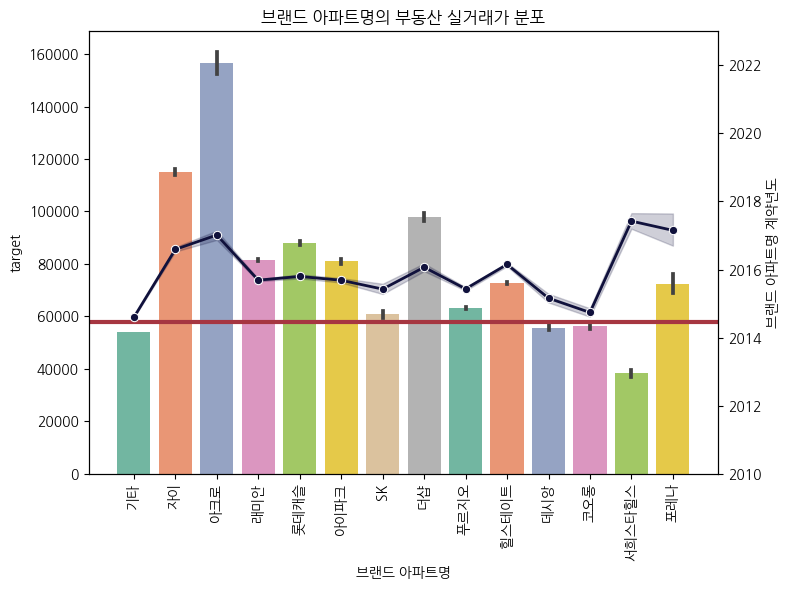

In [92]:
fig, ax1 = plt.subplots(figsize=(8, 6))
sns.barplot(data=df_brand, x='브랜드아파트명', y='target', palette='Set2', ax=ax1)
ax1.set_title('브랜드 아파트명의 부동산 실거래가 분포')
ax1.set_xlabel('브랜드 아파트명')
plt.xticks(rotation=90)
plt.axhline(y=np.mean(df_brand['target']), xmin=0, xmax=1, color='#A63641', linestyle='solid', linewidth=3)

ax2 = ax1.twinx()
ax2.set_ylabel('브랜드 아파트명 계약년도')
ax2.set_ylim(2010, 2023)
sns.lineplot(data=df_brand,x='브랜드아파트명', y='계약년', marker='o', 
             color='#10113C', linestyle='-', linewidth=2, ax=ax2)

fig.tight_layout()
plt.show()

In [93]:
brand_list = ['래미안', '힐스테이트', '자이', '아크로', '더샵', '롯데캐슬', '아이파크', '포레나']
pattern = '|'.join(brand_list)

df_final.loc[df_final['아파트명'].str.contains(pattern), '브랜드아파트유무'] = True
df_final.loc[~df_final['아파트명'].str.contains(pattern), '브랜드아파트유무'] = False

In [94]:
df_final['브랜드아파트유무'].value_counts()

False    1002995
True      125099
Name: 브랜드아파트유무, dtype: int64

In [95]:
df_final.to_csv('data.csv', float_format='%.2f', index=False)